<a href="https://colab.research.google.com/github/tgalkovskyi/deep-text-recognition-benchmark/blob/master/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This can be executed in https://colab.research.google.com "Python 3 / GPU" runtime.

In [1]:
!git clone https://github.com/clovaai/deep-text-recognition-benchmark
%cd deep-text-recognition-benchmark

Cloning into 'deep-text-recognition-benchmark'...
remote: Enumerating objects: 495, done.
remote: Total 495 (delta 0), reused 0 (delta 0), pack-reused 495
Receiving objects: 100% (495/495), 3.07 MiB | 3.50 MiB/s, done.
Resolving deltas: 100% (301/301), done.
/workspace/vision/Nawaf/OCR/Codes/deep_text_recognition_benchmark_colvaai_official/deep-text-recognition-benchmark


Next, download large model files from Google Drive, using hack: https://stackoverflow.com/questions/20665881/direct-download-from-google-drive-using-google-drive-api/32742700#32742700

In [7]:
models = {
    'None-ResNet-None-CTC.pth': 'https://drive.google.com/open?id=1FocnxQzFBIjDT2F9BkNUiLdo1cC3eaO0',
    'None-VGG-BiLSTM-CTC.pth': 'https://drive.google.com/open?id=1GGC2IRYEMQviZhqQpbtpeTgHO_IXWetG',
    'None-VGG-None-CTC.pth': 'https://drive.google.com/open?id=1FS3aZevvLiGF1PFBm5SkwvVcgI6hJWL9',
    'TPS-ResNet-BiLSTM-Attn-case-sensitive.pth': 'https://drive.google.com/open?id=1ajONZOgiG9pEYsQ-eBmgkVbMDuHgPCaY',
    'TPS-ResNet-BiLSTM-Attn.pth': 'https://drive.google.com/open?id=1b59rXuGGmKne1AuHnkgDzoYgKeETNMv9',
    'TPS-ResNet-BiLSTM-CTC.pth': 'https://drive.google.com/open?id=1FocnxQzFBIjDT2F9BkNUiLdo1cC3eaO0',
}

for k, v in models.items():
  doc_id = v[v.find('=')+1:]
  !curl -c /tmp/cookies "https://drive.google.com/uc?export=download&id=$doc_id" > /tmp/intermezzo.html
  !curl -L -b /tmp/cookies "https://drive.google.com$(cat /tmp/intermezzo.html | grep -Po 'uc-download-link" [^>]* href="\K[^"]*' | sed 's/\&amp;/\&/g')" > $k

!ls -al *.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2230    0  2230    0     0   4091      0 --:--:-- --:--:-- --:--:--  4084
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   548  100   548    0     0    907      0 --:--:-- --:--:-- --:--:--   907
100  113k    0  113k    0     0   123k      0 --:--:-- --:--:-- --:--:--  123k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   To

In [2]:
output = !CUDA_VISIBLE_DEVICES=cpu python demo.py \
--Transformation TPS --FeatureExtraction ResNet --SequenceModeling BiLSTM --Prediction CTC \
--image_folder /workspace/vision/Nawaf/OCR/Datasets/WC_test_cases \
--saved_model /workspace/vision/Nawaf/OCR/Codes/deep_text_recognition_benchmark_colvaai_official/saved_models/TPS_ResNet_BiLSTM_CTC_cleaned_synth10M_77_charset/best_accuracy_98_179.pth

In [3]:
output

['model input parameters 32 100 20 1 512 256 37 25 TPS ResNet BiLSTM CTC',
 'loading pretrained model from /workspace/vision/Nawaf/OCR/Codes/deep_text_recognition_benchmark_colvaai_official/saved_models/TPS_ResNet_BiLSTM_CTC_cleaned_synth10M_77_charset/best_accuracy_98_179.pth',
 'Traceback (most recent call last):',
 '  File "demo.py", line 129, in <module>',
 '    demo(opt)',
 '  File "demo.py", line 33, in demo',
 '    model.load_state_dict(torch.load(opt.saved_model, map_location=device))',
 '  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1406, in load_state_dict',
 "    raise RuntimeError('Error(s) in loading state_dict for {}:\\n\\t{}'.format(",
 'RuntimeError: Error(s) in loading state_dict for DataParallel:',
 '\tsize mismatch for module.Transformation.GridGenerator.P_hat: copying a param with shape torch.Size([38400, 23]) from checkpoint, the shape in current model is torch.Size([3200, 23]).',
 '\tsize mismatch for module.Prediction.weight: co

,img,id,label,conf
0,,/workspace/vision/Nawaf/OCR/Datasets/test_inf_images/Screenshot from 2022-07-26 16-42-28.png,نمذجة,0.4799
1,,/workspace/vision/Nawaf/OCR/Datasets/test_inf_images/Screenshot from 2022-07-26 16-42-46.png,نمذجة,0.5241

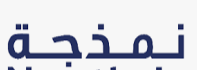
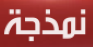

In [9]:
from IPython.core.display import display, HTML
from PIL import Image
import base64
import io
import pandas as pd

data = pd.DataFrame()
for ind, row in enumerate(output[output.index('image_path               \tpredicted_labels         \tconfidence score')+2:]):
    try:

        row = row.split('\t')
        filename = row[0].strip()
        label = row[1].strip()
        conf = row[2].strip()
        img = Image.open(filename)
        img_buffer = io.BytesIO()
        img.save(img_buffer, format="PNG")
        imgStr = base64.b64encode(img_buffer.getvalue()).decode("utf-8") 

        data.loc[ind, 'img'] = '<img src="data:image/png;base64,{0:s}">'.format(imgStr)
        data.loc[ind, 'id'] = filename
        data.loc[ind, 'label'] = label
        data.loc[ind, 'conf'] = conf
    except Exception as e:
        pass
html_all = data.to_html(escape=False)
display(HTML(html_all))